# 2.9.Stepik ML contest

Мы продолжаем предсказывать отток студентов с курса по Анализу данных в R. В этом модуле мы завершим подготовительный этап и доведем данные до состояния, когда можно обучить первый вариант модели!

## step 2

Итак, возвращаемся к нашей практической задаче - предсказание оттоков пользователей со степика.

В первом модуле мы закончили довольно важный и при этом довольно понятный этап для любой задачи, возникающей в `machine-learning`, аналитике, `data-mining` и т.д. У нас просто были какие-то сырые данные, и мы привели их к более понятному виду. Мы их смёрджили, предобработали, агрегировали. Мы как минимум получили понятную историю в этих данных, посмотрели, что всё с этими данными всё хорошо и с ними можно работать.

На самом деле ещё даже до применения моделей (особенно когда речь идёт о продуктовой аналитике и у нас есть цель скажем, разобраться почему пользователи дропаются) уже какие-то гипотезы можно получить, просто посмотрев на такой промежуточный агрегат. 

Допустим, уже сейчас можно изучить последние сессии дропнувшихся пользователей и убедиться в том, что один из таких частых сценариев - это когда человек натыкается на какую-то сложную задачу, очень долго подряд не может её решить и потом уже никогда к нашему курсу не возвращается.

В своё время, когда автор курса работал в степике, он первым делом пробежался по своим курсам и отредактировал довольно много задач. Особенно в курсе по `R`. Буквально в первом-втором уроке была сложная задача на работу с временными рядами и временные ряды до этого не обсуждались. Автору казалось, что самостоятельная работа слушателей с материалами по данной теме приведёт к положительному эффекту. На практике выяснилось, что огромное количество людей доходили до этой задачи, не могли её решить и больше никогда не появлялись на этом курсе.

И тут уже некоторый описательный анализ данных помог эту задачу изменить. на была перенесена в конец урока, выведена под звёздочку, было сказано, что необязательно решать её сейчас, поскольку можно пройти по курсу вперёд, а потом вернуться к её решению. И это в дальнейшем повлияло на результат.

Таким образом, некоторые интересные вещи ещё до моделирования, до обучения могут броситься в глаза.

Сейчас перед нами стоит задача продвинуться чуть дальше и привести данные к тому формату, когда уже можно будет обучать какие-то модели, делать интересные предсказания. 

Давайте переформулируем нашу задачу на язык машинного обучения. Наша цель как можно раньше предсказать, что пользователь уйдёт с курса `"Анализ данных в R"` и давайте для начала решим первую версию задачи. Для этого ответим на опрос - "можем ли мы, анализируя поведения пользователя за первые N дней, предсказать тот факт, что пользователь пройдёт курс до конца или дропнется и не наберёт нужное количество баллов?".

## Подгрузка предыдущих наработок

Подгружу в данный ноутбук наши ранее выполненные наработки.

In [140]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# reading datasets
events_data = pd.read_csv('event_data_train.zip', compression='zip')
submissions_data = pd.read_csv('submissions_data_train.zip', compression='zip')

In [141]:
# adding new columns
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

# calculating for each user count correct submimit
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

now = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_data = users_data.merge(users_events_data, how='outer')

users_days = events_data.groupby('user_id').day.nunique()
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 175

In [142]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [143]:
# Проверка, что данные не потеряны
users_data.user_id.nunique()

19234

In [144]:
events_data.user_id.nunique()

19234

Количество строк совпало, значит мы ничего не потеряли.

## step 3

На предыдущем этапе мы остановились на том, что предобработали данные и сделали сводную выгрузку users_data. 

Из сырых логов и разных источников мы свели все данные воедино. И, в принципе, можно наполнить эту табличку ещё несколькими важными колонками, но сейчас основная идея этой таблички была в том, что у нас были сырые логи, а теперь есть датафрейм users_data, в котором про каждого пользователя мы знаем:

+ его статус на текущий момент (правда ли, что он закончил курс успешно / дропнулся), + сколько он сделал попыток,   
+ когда его последний раз видели на курсе.

То есть пока ещё датафрейм, наверное, не очень применим для какого-то машинного обучения, хотя какие-то гипотезы можно уже и отсюда повытаскивать. Однако этот датафрейм нам точно потребуется ещё не раз, потому что, например, его можно использовать для разметки нашей выборки.

Теперь давайте подбираться к нашей первой задаче машинного обучения - попробуем, анализируя поведение пользователя за его первые несколько дней, после которых он начал курс, предсказать - правда ли, что он успешно закончит курсу или дропнется с него.

Для начала можно предположить, что мы можем использовать, скажем, первые 2-3 дня. Вообще, есл бы мы решали эту задачу по-настоящему - это как раз тот пример. когда у нас нет готового правильного ответа на вопрос "сколько первых дней нам нужно, чтобы предсказать уйдёт пользователь с курса или нет?". Поэтому можно попробовать разные пороги, нащупать какой-то оптимальный баланс времени и качества. Понятное дело, что если мы будем использовать первые две недели, то мы слишком поздно будем реагировать. Если мы будем пытаться предсказывать поведение пользователя за первые два часа с момента его начала работы с курсом - это, конечно, здорово, но возможно мы потеряем в точности.

Поэтому нужно экспериментировать и давайте начнём, например, с 3-х дней. Для начала можно в принципе проверить насколько это адекватно, потому что у нас есть данные про то сколько уникальных дней пользователь потратил на прохождение курса - колонка day. Можно посчитать медиану, предварительно отобрав только те наблюдения, у которых `passed_course = True`.

Обратите внимание, что это уже вектор True\False, поэтому можно просто передать его в качестве фильтра. Хотя это возможно не очень правильно, но так можно сделать.

добавим ещё одну колонку - когда пользователь первый раз появился на курсе.

In [145]:
users_data[users_data.passed_course].day.median()

21.0

Мы видим, что медиана у нас 20 дней. Если построить гистограмму, то мы увидим типично скошенную метрику.

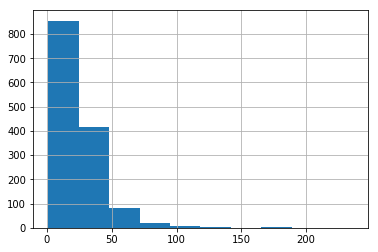

In [146]:
users_data[users_data.passed_course].day.hist()

Кстати, это тоже интересное наблюдение - большинство метрик, как-то характеризующих взаимодействие пользователя с продуктом, очень часто распределены не нормально. Скажем, процент лайков, репостов в соцсетях, количество дней, затраченных пользователями на прохождение курса, число решённых задач и т.д. Скорее всего это будет ненормальное распределение (готовьтесь к этому). Такие классические симметричные распределения на самом деле в реальной практике на самом деле попадаются довольно редко.

Мы видим, что медиана 20, т.е. половина пользователей решает более 20 дней, поэтому 3 дня кажется адекватным порогом. Попробуем предсказать

## step 4

Итак, наша первая задача: отобрать те наблюдения, которые мы будем использовать для обучения `events_data`, т.е. события, происходящие с пользователем в течение его первых трёх дней из общего датафрейма.

Сейчас здесь для каждого пользователя лежит вся его информация про все его действия на протяжении всей истории, доступной нам в этой выгрузке. Нам бы нужно для каждого юзера отобрать только его события, укладывающиеся в диапазон от его первого события плюс 3 дня. 

Как же это сделать?

Отберём данные о первых активных действиях пользователя на курсе:

In [147]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [148]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


Теперь мы можем добавить эту информацию в наш исходный датасет:

In [149]:
users_data = users_data.merge(user_min_time, how='outer')

In [150]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Теперь у нас есть информация не только про то, когда пользователь впервые был на курсе, но и когда он завершил своё действие на курсе - какой у него был последний `timestamp`.

Теперь смотрите, довольно необычная задача и такую фильтрацию мы ещё не делали. Нам теперь нужно для данных, хранящихся в `events_data`, отобрать только наблюдения, проходящие по некоторому условию, а именно - у нас для каждого юзера есть некоторое его окно, в которое мы можем уместить нужные нам наблюдения, и их то и нужно отобрать.

Задача довольно интересная, потому что это такая нетривиальная фильтрация и решить её можно несколькими способами.

Давайте попробуем начать с самого неправильного.

### "Неправильный" способ

На самом деле неправильным его можно назвать в кавычках, это такой наиболее интуитивный способ. 

Смотрите, что у нас происходит. Если мы хотим отобрать для каждого пользователя только нужную часть данных о нём, мы могли бы воспользоваться вот таким подходом:

In [151]:
event_data_train = pd.DataFrame() # сюда сложим уже отобранные данные

А дальше просто написали бы такой цикл:

In [153]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    break

In [154]:
min_user_time

1472827464

In [155]:
user_id

1

Проверим, что всё правильно:
+ выведем первые несколько строк из `users_data`
+ посмотрим какое значение `min_timestamp` у записи с `user_id = 1`

In [177]:
users_data[['user_id', 'min_timestamp']].head(3)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476


Да, всё верно.

А теперь сделаем нужную фильтрацию из исходного датафрейма

In [178]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
    
    break

**================================================= Важно ========================================================**

Выход `break` из цикла после первой итерации - хорошая привычка. Когда вы разрабатываете какой-то сложный цикл - не нужно ждать, пока он весь отработает, есть смысл проверить корректность работы первой итерации.
И только потом прогружать его полностью.

**================================================================================================================**

In [179]:
user_events_data

,step_id,timestamp,action,user_id,date,day
1347416,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02
1347417,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02


Мы получили датафрейм для первого юзера из событий в его первые 3 дня на курсе. Всё корректно отработало - убираем `break` из цикла и наращиваем наш итоговый датафрейм.

In [ ]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
    
    event_data_train.append(user_events_data)

Но! Выполнение данного блока кода займёт очень длительное время. Причина в том, что такого рода операции над датафреймами очень затратные, поскольку выполняются: фильтрация, append не очень эффективен.

В общем, такой подход выбивается из кода, написанного ранее и такой код не `pandas way`.

А что же тогда `pandas way`?

Одной командой, одной маской сделать `event_data_train`, указав, что это `event_data` с некоторым условием:

In [ ]:
event_data_train = event_data[]

То есть это такой путь, при котором наша задача решилась одним запросом на фильтр.

Это довольно интересная задача и решить её можно разными способами. Это немного неочевидный ответ как её решить. 

## step 5

Итак, давайте попробуем придумать как нам сделать один запрос к нашим `events_data`, чтобы получить нужный результат, точнее, чтобы отобрать для каждого пользователя только события, вписывающиеся в промежуток первых трёх дней после начала курса.

Как к этой задачке подойти?

Мы не можем сделать фильтрацию только по `user_id`, нам нужно сложное комбинированное условие по `user_id` и `timestamp`. Для каждого `user_id` границы `timestamp` разные и как к этому подойти - непонятно.

Давайте создадим в `events_data` новую колонку `user_time`:

In [184]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

Инструкция `map(str)` применит к каждому значению в столбце датафрейма функцию str() - т.е. приведёт все значения к строковому типу.

In [185]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


Мы сшили идентификатор пользователя со значениями времени. 

Вынесем переменную порогового значения для `timestamp`, которую мы будем использовать далее:

In [187]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

Теперь давайте для каждого пользователя сделаем связку его идентификатора и максимального значения, которое можно использовать для того, чтобы продолжать работу.

У нас есть уже подготовленный `user_min_time` и давайте теперь сделаем заготовленную серию, в которой для каждого пользователя будут проставлены его максимальное значение времени и сам идентификатор пользователя, после которого мы уже не будем эти данные использовать.

In [188]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [190]:
user_learning_time_treshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

## step 6

Давайте вынесем результат этого вычисления в отдельную колонку. Можем, например, добавить в наш датафрейм, хранящий минильное время юзера. Это будет как раз минимум и максимум, который мы будем использовать для отсечения событий.

In [194]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

Теперь начинается самое интересное - нам нужно просто данные про пороговое значение для каждого пользователя добавить в наш датафрейм `events_data`.

Давайте сделаем мёрдж наших данных с датафреймом `user_min_time`, отобрав из него только нужные нам данные

In [200]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [201]:
events_data.shape

(3480703, 8)

In [202]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Нам теперь для каждого пользователя достаточно просто узнать - "правда ли, что его время выполнения каждого действия вписыается в нужный нам диапазон?".

И тут нам на помощь приходит то, что строки можно сравнивать так же как инты.

In [203]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [204]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [205]:
events_data_train.shape

(1014985, 8)

## step 8

## step 9

## step 10

## step 11

## step 12

## step 13